In [1]:
# Install dependencies
!pip install pyspark==3.5.0 delta-spark==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=ff758e1e152b8a91e40ac93a10e46879c96618b243113c683800a864aee0a0c0
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [2]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
builder = (
SparkSession.builder.appName("DeltaDemo")
.config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog",
"org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [5]:
# Create sample DataFrame
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

In [4]:
df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



1. Managed vs Unmaaged Tables

In [10]:
# Task 1 : Managed and unmanaged tables
# Managed Table
spark.sql("""
CREATE TABLE orders_managed
USING DELTA
AS SELECT * FROM delta.`/tmp/orders_delta`
""")

# Unmanaged table
spark.sql("""
CREATE TABLE orders_unmanaged
USING DELTA
LOCATION '/tmp/orders_delta'
""")

DataFrame[]

2. CRUD Operations

In [11]:
## Read from table

spark.sql("select * from orders_managed").show()
#spark.sql("select * from orders_unmanaged").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [14]:
# Update all 'clothing' category orders to have amount = amount + 20
from delta.tables import DeltaTable

delta_table = DeltaTable.forPath(spark, "/tmp/orders_delta")

delta_table.update(condition="category = 'Clothing'", set={"amount": "amount + 20"})


In [18]:
delta_table.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [17]:
# Delete all orders with quantity < 2
from pyspark.sql.functions import col

delta_table.delete(condition = col("quantity") < 2 )


In [19]:
# Merge in a new dataset (new orders & updated orders)
new_data = [
    (2, "Sara", "Clothing", 1, 120),   # Updated
    (5, "Liam", "Furniture", 2, 500)   # New
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
new_orders = spark.createDataFrame(new_data, columns)

delta_table.alias("old").merge(new_orders.alias("new"), "old.order_id = new.order_id").whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

delta_table.toDF().show()



+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       2|   500|
|       2|         Sara|   Clothing|       1|   120|
+--------+-------------+-----------+--------+------+



3. History & Time Travel

In [21]:
# Use DESCRIBE HISTORY to check previous versions
spark.sql("describe history delta.`/tmp/orders_delta`").show()


+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      3|2025-08-14 06:24:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          2|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      2|2025-08-14 06:09:...|  NULL|    NULL|   DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      1|2

In [23]:
# Read data from version 0 and compare with the latest version

df_v0 = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")

print("Version 0 ")
df_v0.show()

df_latest = spark.read.format("delta").load("/tmp/orders_delta")

print("Latest version")
df_latest.show()

Version 0 
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

Latest version
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       2|   500|
|       2|         Sara|   Clothing|       1|   120|
+--------+-------------+-----------+--------+------+



4. Incremental Load Pattern

In [24]:
# Mini batch
new_b_data=[(5,"Andrew", "Furniture", 2, 800), (6, "Emma", "Clothing",1,1200)]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]

new_batch = spark.createDataFrame(new_b_data, columns)

# Append to Delta Table

new_batch.write.format("delta").mode("append").save("/tmp/orders_delta")

# Final dataset
final_data = spark.read.format("delta").load("/tmp/orders_delta")
final_data.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       5|       Andrew|  Furniture|       2|   800|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       2|   500|
|       2|         Sara|   Clothing|       1|   120|
|       6|         Emma|   Clothing|       1|  1200|
+--------+-------------+-----------+--------+------+



In [25]:
delta_table.toDF().show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       5|       Andrew|  Furniture|       2|   800|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       5|         Liam|  Furniture|       2|   500|
|       2|         Sara|   Clothing|       1|   120|
|       6|         Emma|   Clothing|       1|  1200|
+--------+-------------+-----------+--------+------+



5. Simple  Streaming Read

In [27]:
# Read the /tmp/orders_delta in streaming mode
stream_df = spark.readStream.format("delta").load("/tmp/orders_delta")

# Output to console every 5 seconds (only new data)
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime="5 seconds").start()

query.awaitTermination(45)

False

6. Visualization

In [43]:
# Read Delta table into Pandas

# print(type(delta_table)) - Delta Table
from pyspark.sql.functions import sum as _sum

df = delta_table.toDF().groupBy('category').agg(_sum('amount').alias('total_amount'))
# print(type(df)) - spark DataFrame

pdf =df.toPandas()
print(pdf)
# print(type(pdf)) - Pandas DataFrame

      category  total_amount
0  Electronics           900
1     Clothing          1490
2    Furniture          1300


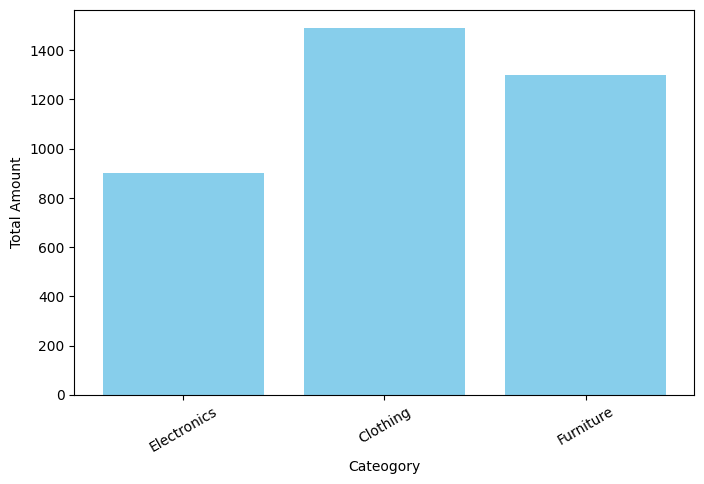

In [45]:
# Create a bar chart of category vs total amount
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(pdf['category'], pdf['total_amount'], color='skyblue')
plt.xlabel("Cateogory")
plt.ylabel("Total Amount")
plt.xticks(rotation=30)
plt.show()